In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload
%autoreload 2
# %pdb
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

from adjustText import adjust_text

fig.initialize()

import foundation as fd
from foundation import models
from foundation import util
from foundation.op.analysis import Run_Manager
from foundation.data import Intervention_Sampler

from sklearn.decomposition import PCA
import sklearn.datasets

from sae_src import sample_full_interventions, response_mat, factor_reponses

# import gpumap
from c3linearize import linearize, class_graph

In [2]:

def preset_figure_info(info):
    plt.rc('font', size=info.small_font_size)          # controls default text sizes
    plt.rc('axes', titlesize=info.small_font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=info.medium_font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=info.small_font_size)    # legend fontsize
    plt.rc('figure', titlesize=info.large_font_size)  # fontsize of the figure title
    

info = util.adict()

info.fsize = (9,6)

info.device = 'cuda'

info.results_name = 'final'
# info.results_name = 'results'

info.small_font_size = 14
info.medium_font_size = 16
info.large_font_size = 18

info.colors = {0: 'C0', 1: 'C1', 2: 'C2'}
info.group_names = {0:'Baseline', 1: 'Structural', 2:'Ladder', 3:'Ada-IN', }

preset_figure_info(info)
print(info)

t{fsize, device, results_name, small_font_size, medium_font_size, large_font_size, colors, group_names}


In [3]:
raw = '''AE	3ds_ae0_e-c12_d-c12_mish_210125-050038	toy_ae_e-c12_d-c12_mish_210125-222234	sim_ae_e-c12_d-c12_mish_210126-035850	real_ae_e-c12_d-c12_mish_210126-035928
VAE1	3ds_vae1_e-c12_d-c12_mish_210125-140254	toy_vae1_e-c12_d-c12_mish_210126-122537	sim_vae1_e-c12_d-c12_mish_210126-123641	real_vae1_e-c12_d-c12_mish_210126-123340
VAE2	3ds_vae2_e-c12_d-c12_mish_210125-140255	toy_vae2_e-c12_d-c12_mish_210126-122537	sim_vae2_e-c12_d-c12_mish_210126-123642	real_vae2_e-c12_d-c12_mish_210126-123340
VAE4		toy_vae4_e-c12_d-c12_mish_210127-231812	sim_vae4_e-c12_d-c12_mish_210127-231257	real_vae4_e-c12_d-c12_mish_210127-231852
VAE8		toy_vae8_e-c12_d-c12_mish_210127-231816	sim_vae8_e-c12_d-c12_mish_210127-231257	real_vae8_e-c12_d-c12_mish_210127-231853
WAE10	3ds_wae10_e-c12_d-c12_mish_210125-140253	toy_wae10_e-c12_d-c12_mish_210126-122537	sim_wae10_e-c12_d-c12_mish_210126-123641	real_wae10_e-c12_d-c12_mish_210126-123340
WAE100	3ds_wae100_e-c12_d-c12_mish_210125-221143	toy_wae100_e-c12_d-c12_mish_210126-122537	sim_wae100_e-c12_d-c12_mish_210126-123641	real_wae100_e-c12_d-c12_mish_210126-123340
WAE1000	3ds_wae1000_e-c12_d-c12_mish_210125-221142	toy_wae1000_e-c12_d-c12_mish_210126-122537	sim_wae1000_e-c12_d-c12_mish_210126-123641	real_wae1000_e-c12_d-c12_mish_210126-123339
AE S2		toy_ae_e-c12_d-s2_mish_210127-231820	sim_ae_e-c12_d-s2_mish_210127-231304	real_ae_e-c12_d-s2_mish_210127-231829
AE S2 nosplit			sim_ae_e-c12_d-s2_nosplit-mish_210127-231312	
AE S3		toy_ae_e-c12_d-s3_mish_210127-231823	sim_ae_e-c12_d-s3_mish_210127-231307	real_ae_e-c12_d-s3_mish_210127-231829
AE S3 nosplit			sim_ae_e-c12_d-s3_nosplit-mish_210127-231312	
AE S4	3ds_ae0_e-c12_d-s4_mish_210125-140253	toy_ae_e-c12_d-s4_mish_210126-122536	sim_ae_e-c12_d-s4_mish_210127-231308	real_ae_e-c12_d-s4_mish_210126-123339
AE S4 nosplit			sim_ae_e-c12_d-s4_nosplit-mish_210127-231315	
AE S6	3ds_ae0_e-c12_d-s6_mish_210125-140253	toy_ae_e-c12_d-s6_mish_210126-122536	sim_ae_e-c12_d-s6_mish_210127-231308	real_ae_e-c12_d-s6_mish_210126-123339
AE S6 nosplit			sim_ae_e-c12_d-s6_nosplit-mish_210127-231313	
AE S12	3ds_ae0_e-c12_d-s12_mish_210125-050335	toy_ae_e-c12_d-s12_mish_210125-222233	sim_ae_e-c12_d-s12_mish_210126-035851	real_ae_e-c12_d-s12_mish_210127-231831
AE S12 nosplit			sim_ae_e-c12_d-s12_nosplit-mish_210127-231314	real_ae_e-c12_d-s12_nosplit-mish_210127-231851
VAE1 L2				
VAE1 L3				
VAE1 L4	3ds_vae1_e-l4_d-l4_mish_210125-134914		sim_vae1_e-l4_d-l4_mish_210127-231449	
VAE1 L6	3ds_vae1_e-l6_d-l6_mish_210125-140021		sim_vae1_e-l6_d-l6_mish_210127-231447	
VAE1 L12	3ds_vae1_e-l12_d-l12_mish_210125-140249		sim_vae1_e-l12_d-l12_mish_210127-231450	real_vae1_e-l12_d-l12_mish_210127-231847'''

model_tbl = [row.split('\t') for row in raw.split('\n')]
headers = ['Name', '3D-Shapes', 'MPI3D Toy', 'MPI3D Sim', 'MPI3D Real']
dataset_names = headers[1:]
all_model_names = {ds:{} for ds in dataset_names}
for title, *names in model_tbl:
    for path, ds in zip(names, dataset_names):
        if path is not None and len(path):
            all_model_names[ds][title] = path
print(tabulate(model_tbl, headers=headers))
len(model_tbl)

Name            3D-Shapes                                   MPI3D Toy                                   MPI3D Sim                                      MPI3D Real
--------------  ------------------------------------------  ------------------------------------------  ---------------------------------------------  ----------------------------------------------
AE              3ds_ae0_e-c12_d-c12_mish_210125-050038      toy_ae_e-c12_d-c12_mish_210125-222234       sim_ae_e-c12_d-c12_mish_210126-035850          real_ae_e-c12_d-c12_mish_210126-035928
VAE1            3ds_vae1_e-c12_d-c12_mish_210125-140254     toy_vae1_e-c12_d-c12_mish_210126-122537     sim_vae1_e-c12_d-c12_mish_210126-123641        real_vae1_e-c12_d-c12_mish_210126-123340
VAE2            3ds_vae2_e-c12_d-c12_mish_210125-140255     toy_vae2_e-c12_d-c12_mish_210126-122537     sim_vae2_e-c12_d-c12_mish_210126-123642        real_vae2_e-c12_d-c12_mish_210126-123340
VAE4                                                        toy_va

23

In [4]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\trained_nets')
device = 'cuda'

In [5]:
ds = '3D-Shapes'

info.title = ds
model_names = all_model_names[ds]
len(model_names), model_names.keys()

(12,
 dict_keys(['AE', 'VAE1', 'VAE2', 'WAE10', 'WAE100', 'WAE1000', 'AE S4', 'AE S6', 'AE S12', 'VAE1 L4', 'VAE1 L6', 'VAE1 L12']))

In [6]:
runs = Run_Manager(model_names, root=root, override={'device':device}, pbar=tqdm)

  0%|          | 0/12 [00:00<?, ?it/s]

Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-c12_mish_210125-050038\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae1_e-c12_d-c12_mish_210125-140254\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae2_e-c12_d-c12_mish_210125-140255\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_wae10_e-c12_d-c12_mish_210125-140253\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_wae100_e-c12_d-c12_mish_210125-221143\config.yaml


Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_wae1000_e-c12_d-c12_mish_210125-221142\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s4_mish_210125-140253\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s6_mish_210125-140253\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s12_mish_210125-050335\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae1_e-l4_d-l4_mish_210125-134914\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae1_e-l6_d-l6_mish_210125-140021\config.yaml


Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae1_e-l12_d-l12_mish_210125-140249\config.yaml


In [7]:
runs.map(lambda run: run.get_records())
runs.load_results('eval');

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
run = runs[0]

In [9]:
def _load_fid(run):
    if not hasattr(run, 'stats'):
        run.stats = util.adict()
    run.stats['rec_loss'] = run.records.stats._archive['val']['100000']['loss']['avg']
    e = run.get_results('eval')
    if 'rec_fid' in e:
        run.stats['rec_fid'] = e['rec_fid']
    if 'hybrid_fid' in e:
        run.stats['hybrid_fid'] = e['hybrid_fid']
    if 'prior_fid' in e:
        run.stats['prior_fid'] = e['prior_fid']
runs.map(_load_fid);

  0%|          | 0/12 [00:00<?, ?it/s]

In [13]:
groups = {'AE':0, 'VAE1':0, 'VAE2':0, 'VAE4':0, 'VAE8':0, 'WAE10':0, 'WAE100':0, 'WAE1000':0, 'AE S4':1, 'AE S6':1, 'AE S12':1, 'VAE1 L4':2, 'VAE1 L6':2, 'VAE1 L12':2}
titles = {'AE':'AE', 'VAE1':'VAE', 'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, 'AE S4':'S4', 'AE S6':'S6', 'AE S12':'S12', 'VAE1 L4':'L4', 'VAE1 L6':'L6', 'VAE1 L12':'L12'}
def _load_info(run):
    run.info = run.get_config().pull('info', {})
    run.group = groups[run.ident]
    run.title = titles[run.ident]
runs.map(_load_info);

  0%|          | 0/12 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


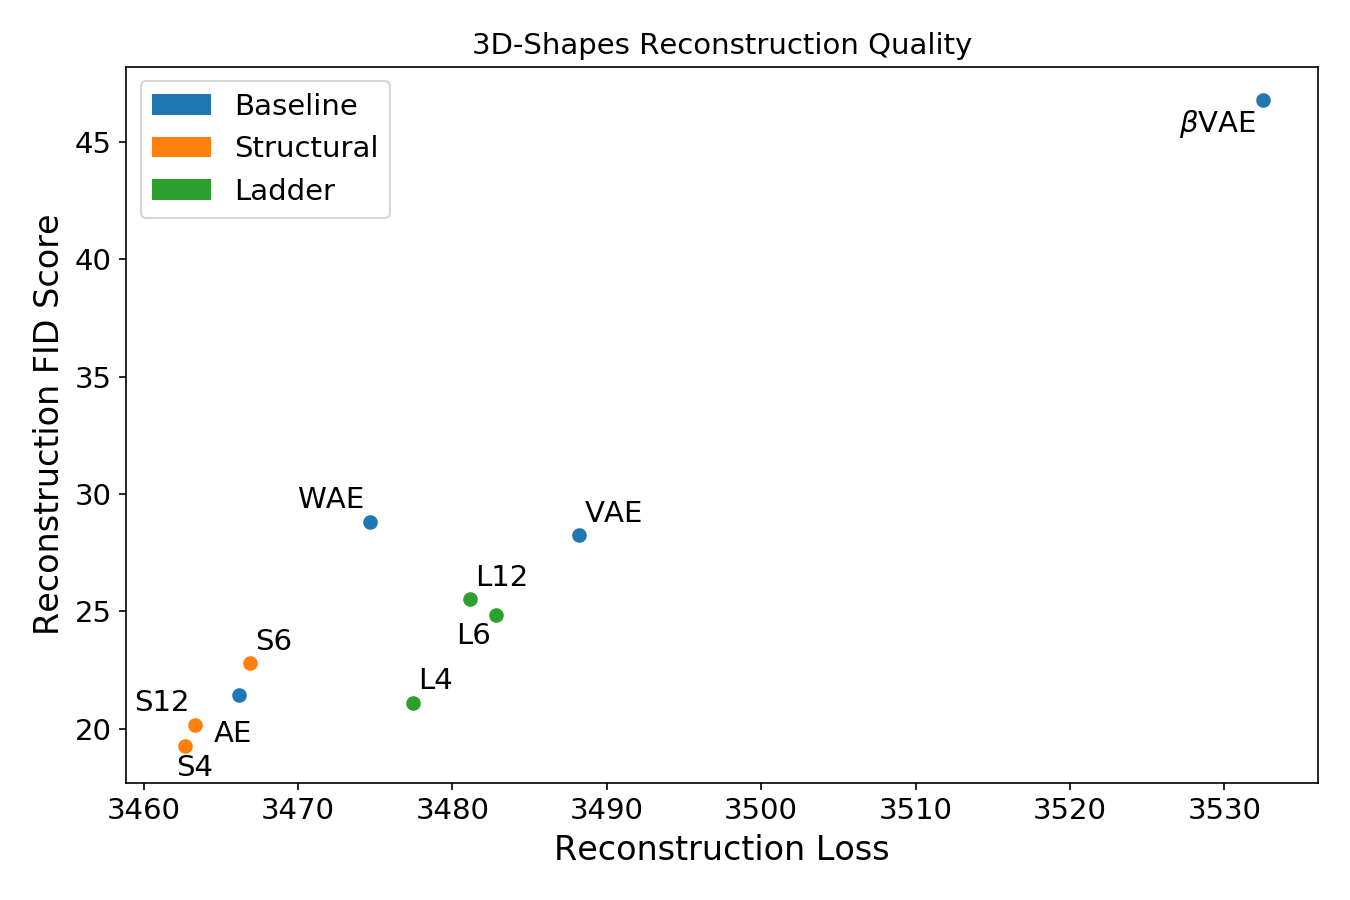

In [14]:
fig, ax = plt.subplots(figsize=info.fsize)

objs = []
texts = []
tps = set()
for r in runs:
    if r.title is not None:
        objs.append(plt.scatter(r.stats.rec_loss, r.stats.rec_fid, color=info.colors[r.group]))
    #     texts.append(plt.text(r.loss-(lossrg/10 if r.type == 'attn' else 0), r.fid, r.name))
        texts.append(plt.text(r.stats.rec_loss, r.stats.rec_fid, r.title, horizontalalignment='center',
          verticalalignment='center',))
        tps.add(r.group)
    #     plt.scatter(r.fid, r.loss, color=colors[r.type])
    #     texts.append(plt.text(r.fid-(fidrg/10 if r.type == 'attn' else 0), r.loss, r.name))

legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in tps]
plt.legend(handles=legend_elements)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Reconstruction FID Score')
plt.title(f'{info.title} Reconstruction Quality')
# plt.xlim(left=6370)
# plt.ylim(bottom=0)
plt.tight_layout()
adjust_text(texts, #force_text=(0.1,0.1)
            #force_text=(0.1,0.25),
            add_objects=objs,
           )
pass


In [12]:
run.results['eval'].keys()

odict_keys(['device', 'original', 'batch', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs', 'rec_fid_stats', 'rec_fid', 'hybrid_fid_stats', 'hybrid_fid'])

In [20]:
names = '''3ds_ae0_e-c12_d-c12_210125-045343
3ds_ae0_e-c12_d-c12_mish_210125-050038
3ds_ae0_e-c12_d-s12_210125-045438
3ds_ae0_e-c12_d-s12_mish_210125-050335
3ds_ae0_e-c12_d-s12_nosplit_210125-045438
3ds_ae0_e-c12_d-s2_210125-132645
3ds_ae0_e-c12_d-s3_210125-134123
3ds_ae0_e-c12_d-s4_seed2_210125-133117
3ds_ae0_e-c12_d-s6_lrp0004_210125-171518
3ds_vae2_e-c12_d-c12_210125-045344
3ds_vae2_e-c12_d-c12_mish_210125-140255
3ds_wae1000_e-c12_d-c12_210125-221143
3ds_wae100_e-c12_d-c12_210125-221143
3ds_vae1_e-c12_d-c12_210125-045347
3ds_vae1_e-l12_d-l12_210125-045439
3ds_vae1_e-c12_d-c12_mish_210125-140254
3ds_vae1_e-l12_d-l12_mish_210125-140249'''.split('\n')
len(names)

17

In [21]:
device = 'cuda'

In [22]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\trained_nets')
run_names = os.listdir(str(root))
len(run_names)

238

In [23]:
def _load_run(name):
    load_config = fig.get_config(path=name, root=str(root), **{'override.device':device})
    load_config.set_silent(True)
    run = fig.run('load-run', load_config)
    return run

In [24]:
runs = [_load_run(name) for name in names]
len(runs)

Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-c12_210125-045343\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-c12_mish_210125-050038\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s12_210125-045438\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s12_mish_210125-050335\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s12_nosplit_210125-045438\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s2_210125-132645\config.yaml


Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s3_210125-134123\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s4_seed2_210125-133117\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s6_lrp0004_210125-171518\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae2_e-c12_d-c12_210125-045344\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae2_e-c12_d-c12_mish_210125-140255\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_wae1000_e-c12_d-c12_210125-221143\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_wae100_e-c12_d-c12_210125-221143\config.yaml


Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae1_e-c12_d-c12_210125-045347\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae1_e-l12_d-l12_210125-045439\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae1_e-c12_d-c12_mish_210125-140254\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_vae1_e-l12_d-l12_mish_210125-140249\config.yaml


17

In [25]:
full = {}
for run in runs:
    full[run.get_name()] = run.get_results('responses')
len(full)

17

In [26]:
full[run.get_name()]['scores']['responses']['disentanglement'].item()

0.9029592275619507

In [27]:
dis = {name: val['scores']['responses']['disentanglement'].item() for name, val in full.items()}
dis

{'3ds_ae0_e-c12_d-c12_210125-045343': 0.42171812057495117,
 '3ds_ae0_e-c12_d-c12_mish_210125-050038': 0.46293771266937256,
 '3ds_ae0_e-c12_d-s12_210125-045438': 0.927747368812561,
 '3ds_ae0_e-c12_d-s12_mish_210125-050335': 0.9850431084632874,
 '3ds_ae0_e-c12_d-s12_nosplit_210125-045438': 0.4851328134536743,
 '3ds_ae0_e-c12_d-s2_210125-132645': 0.6679278016090393,
 '3ds_ae0_e-c12_d-s3_210125-134123': 0.72877436876297,
 '3ds_ae0_e-c12_d-s4_seed2_210125-133117': 0.7457446455955505,
 '3ds_ae0_e-c12_d-s6_lrp0004_210125-171518': 0.8022826313972473,
 '3ds_vae2_e-c12_d-c12_210125-045344': 0.9558988213539124,
 '3ds_vae2_e-c12_d-c12_mish_210125-140255': 0.6085110306739807,
 '3ds_wae1000_e-c12_d-c12_210125-221143': 0.4580004811286926,
 '3ds_wae100_e-c12_d-c12_210125-221143': 0.4243032932281494,
 '3ds_vae1_e-c12_d-c12_210125-045347': 0.678819477558136,
 '3ds_vae1_e-l12_d-l12_210125-045439': 0.8798182606697083,
 '3ds_vae1_e-c12_d-c12_mish_210125-140254': 0.6777613162994385,
 '3ds_vae1_e-l12_d-l12_m

In [31]:
runs[0].get_config().pull('info', silent=True)

{'arch_type': 'c12',
 'dataset_type': '3ds',
 'dec_type': 'c12',
 'enc_type': 'c12',
 'model_type': 'ae',
 'size': 64}

In [32]:
infos = {run.get_name():run.get_config().pull('info', silent=True) for run in runs}
len(infos)

17

In [52]:
titles = {name: '{} {}{}'.format(info['model_type'].upper(), info['dec_type'].upper(), ' mish' if 'mish' in name else '') for name, info in infos.items()}
len(titles)

17

In [53]:
keys = list(titles.keys())
keys = sorted(keys)
x = [titles[n] for n in keys]
y = [dis[n] for n in keys]
len(x), len(y)

(17, 17)

<IPython.core.display.Javascript object>


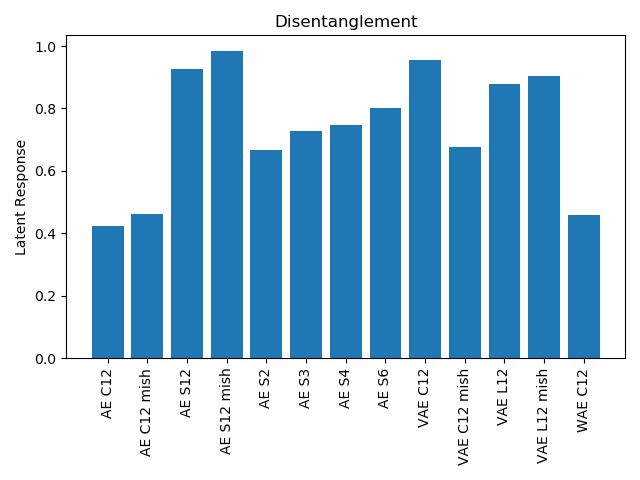

In [55]:
plt.bar(x, y);
plt.xticks(rotation='vertical');
plt.title('Disentanglement')
plt.ylabel('Latent Response')
plt.tight_layout();

In [3]:
run = fig.quick_run('load-run', path=r'C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s2_nosplit_210125-134343')

| [Pushed] _type: 'run'
| CREATING . (type=run)
|  > silent: False (by default)
|  > invisible: False (by default)
|  > path: 'C:\\Users\\anwan\\Documents\\workspace\\sae\\trained_nets\\3ds_ae0_e-c12_d-s2_nosplit_210125-134343'
|  > [Pushed] novel: False
|  > override: [<class 'dict'>] (by default)
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_ae0_e-c12_d-s2_nosplit_210125-134343\config.yaml
|  > [Pushed] path: 'C:\\Users\\anwan\\Documents\\workspace\\sae\\trained_nets\\3ds_ae0_e-c12_d-s2_nosplit_210125-134343'
|  > ckpt-num: None (by default)
|  > best: False (by default)
|  > last: True (by default)
|  > [Pushed] dataset._load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\sae\\trained_nets\\3ds_ae0_e-c12_d-s2_nosplit_210125-134343\\ckpt100000'
|  > [Pushed] model._load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\sae\\trained_nets\\3ds_ae0_e-c12_d-s2_nosplit_210125-134343\\ckpt100000'
|  > [Pushed] records._load-ckpt: 'C:\\Users\\anwan\\Document

In [5]:
e = run.get_results('eval')
e.keys()

odict_keys(['device', 'original', 'batch', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs', 'rec_fid_stats', 'rec_fid', 'hybrid_fid_stats', 'hybrid_fid'])

In [6]:
e['diffs'].shape

torch.Size([16, 12])

In [8]:
f = run.get_results('final-test')
f.keys()

odict_keys(['device', 'original', 'batch', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs', 'rec_fid_stats', 'rec_fid', 'hybrid_fid_stats', 'hybrid_fid'])

In [12]:
f['rec_fid']

0.03641091961960541